In [2]:
import os
import re
import json
import warnings
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold,KFold,cross_val_predict
from sklearn.utils.validation import check_is_fitted
from joblib import Parallel, delayed

In [3]:
base_path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation"

In [4]:
def _normalize_ids(s: pd.Series) -> pd.Series:
    # tout en str, sans espaces, en minuscules
    s = s.astype(str).str.strip().str.lower()
    # retire 'sub-' s'il est présent
    s = s.str.replace(r'^(sub-)', '', regex=True)
    return s



def load_cognition_df() -> pd.DataFrame:
    path = "/neurospin/dico/rmenasria/Runs/03_main/Input/dHCP/cognitive_scores_with_age_dHCP.csv"
    df = pd.read_csv(path)
    if "Participant ID" not in df.columns:
        raise ValueError("Colonne 'Participant ID' absente du CSV de cognition.")
    df["pid_norm"] = _normalize_ids(df["Participant ID"])
    # enlève les doublons éventuels côté cognition (garde le premier)
    df = df.drop_duplicates(subset=["pid_norm"], keep="first")
    return df



def load_embeddings_dHCP(region):
    region_path = os.path.join(base_path, region)
    subdirs = [d for d in os.listdir(region_path) if os.path.isdir(os.path.join(region_path, d))]
    if len(subdirs) != 1:
        raise RuntimeError(
            f"Il y a {len(subdirs)} sous-dossiers dans {region_path}, impossible de choisir automatiquement."
        )
    model_folder = subdirs[0]
    embedding_path = os.path.join(region_path, model_folder, "dHCP_random_embeddings", "full_embeddings.csv")
    embeddings = pd.read_csv(embedding_path, index_col=0)

    # index -> pid_norm
    embeddings.index = _normalize_ids(embeddings.index)
    embeddings.index.name = "pid_norm"

    # dédoublonne si besoin (garde la première occurrence)
    embeddings = embeddings[~embeddings.index.duplicated(keep="first")]

    #print("embeddings shape (avant filtre cognition):", embeddings.shape)
    return embeddings




In [5]:
class ResidualizerSexeFromX(BaseEstimator, TransformerMixin):
    """
    Suppose que la dernière colonne de X est le sexe binaire {0,1}.
    - fit : pour chaque feature j, ajuste x_j ~ a_j + b_j*sexe
    - transform : retourne les résidus (x_j - prédiction), en enlevant la colonne sexe.
    """
    def __init__(self, sex_col_index: int = -1):
        self.sex_col_index = sex_col_index

    def fit(self, X, y=None):
        
        X = np.asarray(X, dtype=float)
        sex = X[:, self.sex_col_index]
        feats = np.delete(X, self.sex_col_index, axis=1)

        # Vérif binaire
        uniq = np.unique(sex[~np.isnan(sex)])
        if not np.all(np.isin(uniq, [0.0, 1.0])):
            warnings.warn("Colonne sexe pas strictement binaire {0,1}.")

        # Formules fermées de la régression OLS par dimension
        s_mean, s_var = np.nanmean(sex), np.nanvar(sex)
        X_mean = np.nanmean(feats, axis=0)

        if s_var <= 0:
            beta = np.zeros(feats.shape[1])
            alpha = X_mean.copy()
        else:
            cov = np.nanmean((feats - X_mean) * (sex[:, None] - s_mean), axis=0)
            beta = cov / s_var
            alpha = X_mean - beta * s_mean

        self.alpha_ = alpha
        self.beta_ = beta
        self.n_features_ = feats.shape[1]
        self.sex_col_index_ = self.sex_col_index
        return self

    def transform(self, X):
        check_is_fitted(self, ["alpha_", "beta_"])
        X = np.asarray(X, dtype=float)
        sex = X[:, self.sex_col_index_]
        feats = np.delete(X, self.sex_col_index_, axis=1)
        pred = self.alpha_[None, :] + sex[:, None] * self.beta_[None, :]
        return feats - pred

In [6]:
@dataclass
class PreparedData:
    X: np.ndarray            # embeddings + sexe concaténés
    y: np.ndarray
    groups: np.ndarray
    idx_keep: np.ndarray
    embedding_cols: List[str]
    n_splits: int


def prepare_dhcp_for_score(
    region: str,
    cognition_col: str,
    prem_class: Optional[List[str]] = None,
    sex_col: str = "Child's Sex",
    group_col: Optional[str] = None,
    min_splits: int = 5
) -> PreparedData:
    emb_df = load_embeddings_dHCP(region)
    cog_df = load_cognition_df()

    # Sanity checks colonnes
    if cognition_col not in cog_df.columns:
        raise ValueError(f"Colonne cognition '{cognition_col}' absente du df cognition.")
    if sex_col not in cog_df.columns:
        raise ValueError(f"Colonne sexe '{sex_col}' absente du df cognition.")

    # Merge sur pid_norm
    merged = cog_df.merge(emb_df, on="pid_norm", how="inner", suffixes=("", "_emb"))
    #print(f"[{region} | {cognition_col}] après merge: {merged.shape[0]} sujets")

    if merged.empty:
        # aide au debug: montre quelques IDs qui ne matchent pas
        miss_left = set(cog_df["pid_norm"]) - set(emb_df.index)
        miss_right = set(emb_df.index) - set(cog_df["pid_norm"])
        #print("Exemples d'IDs cognition sans embedding:", list(miss_left)[:10])
        #print("Exemples d'IDs embedding sans cognition:", list(miss_right)[:10])
        raise ValueError("Merge vide — vérifier la normalisation des IDs.")

    # Filtre prématurés (si demandé et colonne présente)
    if prem_class is not None:
        if "prem_class" in merged.columns:
            before = merged.shape[0]
            merged = merged[merged["prem_class"].isin(prem_class)].copy()
            print(f"Filtre prem_class {prem_class}: {before} -> {merged.shape[0]}")
        else:
            warnings.warn("prem_class demandé mais colonne 'prem_class' absente; filtre ignoré.")

    # map sexe → numérique
    sex_map = {"male": 0, "female": 1, "m": 0, "f": 1}
    merged["_sex_num"] = _normalize_ids(merged[sex_col]).map(sex_map).astype(float)

    # embeddings
    embedding_cols = [c for c in merged.columns if re.match(r"^dim", c)]
    if not embedding_cols:
        raise ValueError("Aucune colonne d'embeddings 'dim...' trouvée après merge.")

    X_emb = merged[embedding_cols].values.astype(float)
    y = merged[cognition_col].values.astype(float)
    sex_vec = merged["_sex_num"].values.astype(float)

    # groups: par défaut = pid_norm
    if group_col is None:
        groups = merged["pid_norm"].astype(str).values
    else:
        if group_col not in merged.columns:
            raise ValueError(f"Colonne de groupe '{group_col}' absente du merged.")
        groups = merged[group_col].astype(str).values

    # clean rows: drop si y ou sex NA
    keep = (~np.isnan(y)) & (~np.isnan(sex_vec))
    X_emb, y, sex_vec, groups = X_emb[keep], y[keep], sex_vec[keep], groups[keep]

    # concatène sexe en dernière colonne 
    X_aug = np.column_stack([X_emb, sex_vec])

    try:
        y_strat = pd.qcut(y, q=3, labels=False, duplicates="drop")
    except Exception:
        y_strat = np.zeros_like(y, dtype=int)

    # Ajuste n_splits si une classe est trop petite
    counts = pd.Series(y_strat).value_counts()
    max_splits = int(counts.min()) if not counts.empty else 2
    n_splits = max(2, min(min_splits, max_splits))
    if n_splits < min_splits:
        warnings.warn(f"Stratification limitée: plus petite classe={max_splits}, n_splits={n_splits}.")

    return PreparedData(
        X=X_aug, y=y, groups=groups, idx_keep=keep,
        embedding_cols=embedding_cols + ["_sex_num"], n_splits=n_splits
    )


In [7]:
def _cv_pred_mean_repeats(X, y, groups, alpha, repeats=50, n_splits=5, seed=0, n_jobs=-1):
    rng = np.random.default_rng(seed)
    preds = []

    def _stratify(v):
        try:
            return pd.qcut(v, q=3, labels=False, duplicates="drop")
        except Exception:
            return np.zeros_like(v, dtype=int)

    for r in range(repeats):
        y_strat = _stratify(y)
        sgkf = StratifiedGroupKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=int(rng.integers(0, 1_000_000))
        )
        pipe_fixed = Pipeline([
            ('resid', ResidualizerSexeFromX()),
            ('scaler', StandardScaler()),
            ('regressor', Ridge(alpha=alpha))
        ])
        y_pred_r = cross_val_predict(
            pipe_fixed, X, y,
            cv=sgkf.split(X, y_strat, groups),
            n_jobs=n_jobs
        )
        preds.append(y_pred_r)

    return np.mean(np.column_stack(preds), axis=1)


def _perm_test_corr(y_true, y_pred_fixed, n_perm=1000, seed=0, side='greater'):
    rng = np.random.default_rng(seed)
    r_obs = pearsonr(y_true, y_pred_fixed)[0]
    null = []
    for _ in range(n_perm):
        y_perm = rng.permutation(y_true)
        null.append(pearsonr(y_perm, y_pred_fixed)[0])
    null = np.asarray(null)

    if side == 'greater':
        p = (np.sum(null >= r_obs) + 1) / (n_perm + 1)
    elif side == 'less':
        p = (np.sum(null <= r_obs) + 1) / (n_perm + 1)
    else:
        p = (np.sum(np.abs(null) >= abs(r_obs)) + 1) / (n_perm + 1)

    crit = np.percentile(null, 95.0)  # seuil critique 5% (unilatéral r>0)
    return float(r_obs), float(p), float(crit)


In [8]:
def bootstrap_cv_residualized_sex2(
    data: PreparedData,
    random_state: int = 42,
    n_jobs: int = -1,
    alphas: Tuple[float, ...] = (0.01, 0.1, 1.0, 10.0),
    repeats: int = 50,
    n_perm: int = 10000,
    n_boot_ci: int = 5000
) -> Dict:
    """
    Évalue l'association entre embeddings et score cognitif avec :
    - CV groupée et stratifiée répétée (repeats fois),
    - corrélation Pearson hors-échantillon (r_cv_mean_repeats),
    - IC95% bootstrap sujets autour de r_cv_mean_repeats,
    - test de permutation unilatéral (r_perm_pvalue_one_sided).
    """
    rng = np.random.default_rng(random_state)
    X, y, groups = data.X, data.y, data.groups

    # Choix de alpha via GridSearchCV
    pipe = Pipeline([
        ('resid', ResidualizerSexeFromX()),
        ('scaler', StandardScaler()),
        ('regressor', Ridge())
    ])
    inner = KFold(n_splits=min(5, data.n_splits), shuffle=True, random_state=0)

    grid = GridSearchCV(
        pipe, {'regressor__alpha': list(alphas)},
        cv=inner, scoring='r2', n_jobs=n_jobs
    )
    grid.fit(X, y)
    best_alpha = float(grid.best_params_['regressor__alpha'])

    # CV répétée : prédictions moyennées par sujet
    y_pred_mean = _cv_pred_mean_repeats(
        X, y, groups,
        alpha=best_alpha,
        repeats=repeats,
        n_splits=data.n_splits,
        seed=random_state,
        n_jobs=n_jobs
    )

    # Corrélation observée + test permutation 
    r_cv, p_perm, r_crit_95 = _perm_test_corr(
        y_true=y,
        y_pred_fixed=y_pred_mean,
        n_perm=n_perm,
        seed=random_state,
        side='greater'
    )

    # Bootstrap sujets pour IC autour de r_cv
    def ci_bootstrap_on_subjects(y_true, y_pred, n_boot=5000, seed=0):
        rng = np.random.default_rng(seed)
        n = len(y_true)
        rs = []
        for _ in range(n_boot):
            idx = rng.integers(0, n, size=n)
            try:
                rs.append(pearsonr(y_true[idx], y_pred[idx])[0])
            except Exception:
                rs.append(np.nan)
        rs = np.array(rs, dtype=float)
        ci = np.nanpercentile(rs, [2.5, 97.5]).tolist()
        return float(np.nanmean(rs)), ci

    r_mean_stable, r_ci_stable = ci_bootstrap_on_subjects(
        y, y_pred_mean, n_boot=n_boot_ci, seed=random_state
    )

    # Résultats
    out = {
        "n": int(len(y)),
        "best_alpha": best_alpha,
        "r_cv_mean_repeats": r_cv,
        "r_cv_mean_repeats_ci": r_ci_stable,
        "r_perm_pvalue_one_sided": p_perm,
        "r_null_95pct": r_crit_95
    }
    return out


In [12]:
from tqdm import tqdm
import time

def bootstrap_cv_residualized_sex(
    data: PreparedData,
    random_state: int = 42,
    n_jobs: int = -1,
    alphas: Tuple[float, ...] = (0.01, 0.1, 1.0, 10.0),
    repeats: int = 50,
    n_perm: int = 5000,
    n_boot_ci: int = 1000,
    repeats_perm: int = 1   # <= nouveau paramètre
) -> Dict:
    """
    Évalue l'association entre embeddings et score cognitif avec :
    - CV groupée et stratifiée répétée (repeats fois),
    - corrélation Pearson hors-échantillon (r_cv_mean_repeats),
    - IC95% bootstrap sujets autour de r_cv_mean_repeats,
    - test de permutation unilatéral avec refit (r_perm_pvalue_one_sided).
    """
    rng = np.random.default_rng(random_state)
    X, y, groups = data.X, data.y, data.groups

    # --- Choix de alpha via GridSearchCV ---
    pipe = Pipeline([
        ('resid', ResidualizerSexeFromX()),
        ('scaler', StandardScaler()),
        ('regressor', Ridge())
    ])
    inner = KFold(n_splits=min(5, data.n_splits), shuffle=True, random_state=0)

    grid = GridSearchCV(
        pipe, {'regressor__alpha': list(alphas)},
        cv=inner, scoring='r2', n_jobs=n_jobs
    )
    grid.fit(X, y)
    best_alpha = float(grid.best_params_['regressor__alpha'])

    # --- CV répétée stable pour r_obs ---
    y_pred_mean = _cv_pred_mean_repeats(
        X, y, groups,
        alpha=best_alpha,
        repeats=repeats,
        n_splits=data.n_splits,
        seed=random_state,
        n_jobs=n_jobs
    )

    # --- Permutations avec refit (rapide via repeats_perm=1) ---
    r_cv, p_perm, r_crit_95 = _perm_test_corr_refit(
        X, y, groups,
        alpha=best_alpha,
        n_splits=data.n_splits,
        n_perm=n_perm,
        seed=random_state,
        n_jobs=n_jobs,
        repeats_perm=repeats_perm
    )

    # --- Bootstrap sujets pour IC autour de r_cv ---
    def ci_bootstrap_on_subjects(y_true, y_pred, n_boot=5000, seed=0):
        rng = np.random.default_rng(seed)
        n = len(y_true)
        rs = []
        for _ in range(n_boot):
            idx = rng.integers(0, n, size=n)
            try:
                rs.append(pearsonr(y_true[idx], y_pred[idx])[0])
            except Exception:
                rs.append(np.nan)
        rs = np.array(rs, dtype=float)
        ci = np.nanpercentile(rs, [2.5, 97.5]).tolist()
        return float(np.nanmean(rs)), ci

    r_mean_stable, r_ci_stable = ci_bootstrap_on_subjects(
        y, y_pred_mean, n_boot=n_boot_ci, seed=random_state
    )

    return {
        "n": int(len(y)),
        "best_alpha": best_alpha,
        "r_cv_mean_repeats": r_cv,
        "r_cv_mean_repeats_ci": r_ci_stable,
        "r_perm_pvalue_one_sided": p_perm,
        "r_null_95pct": r_crit_95
    }


def _perm_test_corr_refit(
    X, y, groups, alpha, n_splits,
    n_perm=1000, seed=0, n_jobs=-1, repeats_perm=1,
    verbose=True
):
    rng = np.random.default_rng(seed)

    # r observé avec repeats élevés (stable)
    y_pred_obs = _cv_pred_mean_repeats(
        X, y, groups,
        alpha=alpha, repeats=50,
        n_splits=n_splits, seed=seed, n_jobs=n_jobs
    )
    r_obs = pearsonr(y, y_pred_obs)[0]

    # distribution nulle
    null = []
    start_time = time.time()
    iterator = tqdm(range(n_perm), disable=not verbose, desc="Permutations")

    for i in iterator:
        y_perm = rng.permutation(y)
        y_pred_perm = _cv_pred_mean_repeats(
            X, y_perm, groups,
            alpha=alpha, repeats=repeats_perm,
            n_splits=n_splits,
            seed=int(rng.integers(0, 1e6)),
            n_jobs=n_jobs
        )
        null.append(pearsonr(y_perm, y_pred_perm)[0])

        # ETA toutes les 100 itérations
        if verbose and (i+1) % 100 == 0:
            elapsed = time.time() - start_time
            speed = elapsed / (i+1)
            eta = speed * (n_perm - (i+1))
            iterator.set_postfix({
                "r_obs": f"{r_obs:.3f}",
                "ETA": f"{eta/60:.1f} min"
            })

    null = np.asarray(null)
    p = (np.sum(null >= r_obs) + 1) / (n_perm + 1)
    crit = np.percentile(null, 95.0)  # seuil critique 5% (unilatéral r>0)

    return float(r_obs), float(p), float(crit)


In [10]:
def run_regions_scores(
    regions: List[str],
    scores: List[str],
    prem_class: Optional[List[str]] = None,
    random_state: int = 42,
    n_jobs_boot: int = -1,
    alphas: Tuple[float, ...] = (0.01, 0.1, 1.0, 10.0),
    repeats: int = 50,
    n_perm: int = 10000,
    n_boot_ci: int = 5000,
    output_csv: Optional[str] = None
) -> pd.DataFrame:
    rows = []
    for region in regions:
        for score in scores:
            try:
                data = prepare_dhcp_for_score(region, score, prem_class=prem_class)
                res = bootstrap_cv_residualized_sex(
                    data,
                    random_state=random_state,
                    n_jobs=n_jobs_boot,
                    alphas=alphas,
                    repeats=repeats,
                    n_perm=n_perm,
                    n_boot_ci=n_boot_ci
                )
                rows.append({
                    "region": region,
                    "score": score,
                    "n": res["n"],
                    "best_alpha": res["best_alpha"],
                    "r_cv_mean_repeats": res["r_cv_mean_repeats"],
                    "r_cv_mean_repeats_ci_low": res["r_cv_mean_repeats_ci"][0],
                    "r_cv_mean_repeats_ci_high": res["r_cv_mean_repeats_ci"][1],
                    "r_perm_pvalue_one_sided": res["r_perm_pvalue_one_sided"],
                    "r_null_95pct": res["r_null_95pct"],
                })

            except Exception as e:
                warnings.warn(f"[{region} | {score}] failed: {e}")
    df = pd.DataFrame(rows)
    if output_csv:
        df.to_csv(output_csv, index=False)
    return df


In [16]:
# Exemples de régions & scores 
regions_test_2 = [
    "SFinf-BROCA-SPeCinf_right",
    "SFinf-BROCA-SPeCinf_left",
    "ScCal-SLi_left",
    "STi-SOTlat_right",
    "FColl-SRh_right",
    "SFint-FCMant_left",
    "SFint-FCMant_left",
    "STsbr_right",
    "STs_right",
    "OCCIPITAL_right",
]

regions_test = [
    "SFinf-BROCA-SPeCinf_right",
    "STi-SOTlat_right",
    "FColl-SRh_right",
    "SFint-FCMant_left",
    "OCCIPITAL_right",
]

regions2 = ["SC-sylv_right","STsbr_left","OCCIPITAL_left","SFint-FCMant_left","SPoC_right "]

def get_region_list(json_file_path="/neurospin/dico/data/deep_folding/current/sulci_regions_champollion_V1.json"):
   

    with open(json_file_path, 'r') as f:
        data = json.load(f)["brain"]


    def extract_keys(d, sep='_'):
        keys = []
        for k, v in d.items():
            new_key = k
            keys.append(new_key)

        return keys
    
    # Remove all the "." in the keys
    region_list = extract_keys(data)
    region_list = [region.replace('.','') for region in region_list]

    return region_list

regions_2 = get_region_list()
regions = regions_test
print("region_list :",regions)

emb = load_embeddings_dHCP(regions[0])
cog = load_cognition_df()
print("n embeddings:", emb.shape, "n cognition:", cog.shape)
print("intersection IDs:", len(set(emb.index) & set(cog["pid_norm"])))
scores = [
    # "Composite Score",
    # "Communication Composite Score",
    "Receptive Communication Scaled Score",
    # "Expressive Communication Scaled Score",
    # "Sum Communication Scaled Scores",
]
# filtrer prématurés
prem_filter = ['<28','28-32','32-37']  # mettre None pour désactiver
#prem_filter = None

out = run_regions_scores(
    regions=regions,
    scores=scores,
    prem_class=prem_filter,
    random_state=42,
    n_jobs_boot=-1,
    alphas=(0.01, 0.1, 1.0, 10.0),
    repeats=10,
    n_perm=5000,
    n_boot_ci=750,  
    output_csv="/neurospin/dico/rmenasria/Runs/03_main/Output/final/r_boostraped/dhcp_bootstrap_cognition_prema_perm_ISBI_5K_10R.csv" 
)
print(out)

region_list : ['SFinf-BROCA-SPeCinf_right', 'STi-SOTlat_right', 'FColl-SRh_right', 'SFint-FCMant_left', 'OCCIPITAL_right']
n embeddings: (374, 32) n cognition: (354, 15)
intersection IDs: 354
Filtre prem_class ['<28', '28-32', '32-37']: 354 -> 79


Permutations: 100%|██████████| 5000/5000 [05:15<00:00, 15.87it/s, r_obs=-0.185, ETA=0.0 min]


Filtre prem_class ['<28', '28-32', '32-37']: 354 -> 79


Permutations: 100%|██████████| 5000/5000 [05:28<00:00, 15.24it/s, r_obs=0.312, ETA=0.0 min]


Filtre prem_class ['<28', '28-32', '32-37']: 354 -> 79


Permutations: 100%|██████████| 5000/5000 [05:27<00:00, 15.25it/s, r_obs=0.303, ETA=0.0 min]


Filtre prem_class ['<28', '28-32', '32-37']: 354 -> 79


Permutations: 100%|██████████| 5000/5000 [05:16<00:00, 15.82it/s, r_obs=0.218, ETA=0.0 min]


Filtre prem_class ['<28', '28-32', '32-37']: 354 -> 79


Permutations: 100%|██████████| 5000/5000 [05:30<00:00, 15.11it/s, r_obs=0.039, ETA=0.0 min]


                      region                                 score   n  \
0  SFinf-BROCA-SPeCinf_right  Receptive Communication Scaled Score  79   
1           STi-SOTlat_right  Receptive Communication Scaled Score  79   
2            FColl-SRh_right  Receptive Communication Scaled Score  79   
3          SFint-FCMant_left  Receptive Communication Scaled Score  79   
4            OCCIPITAL_right  Receptive Communication Scaled Score  79   

   best_alpha  r_cv_mean_repeats  r_cv_mean_repeats_ci_low  \
0        10.0          -0.185229                 -0.345788   
1        10.0           0.311691                  0.078870   
2        10.0           0.303039                  0.104720   
3        10.0           0.217528                  0.033892   
4        10.0           0.038851                 -0.179853   

   r_cv_mean_repeats_ci_high  r_perm_pvalue_one_sided  r_null_95pct  
0                  -0.004713                 0.822236      0.220638  
1                   0.490674              

/tmp/ipykernel_535409/2274865878.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = annot.applymap(lambda p: "*" if p < 0.05/10 else "")


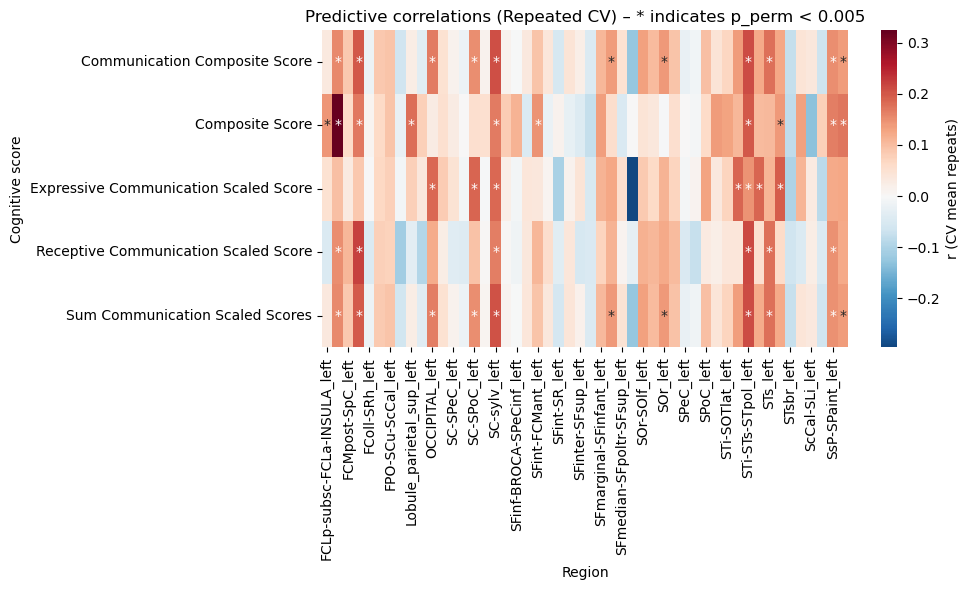

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/r_boostraped/dhcp_bootstrap_cognition_perm_all_regions.csv")

df_small = df[[
    "region",
    "score",
    "r_cv_mean_repeats",
    "r_perm_pvalue_one_sided"
]]


# Pivot for the heatmap
pivot = df_small.pivot(index="score", columns="region", values="r_cv_mean_repeats")

# Create annotation matrix (* if p < 0.005)
annot = df_small.pivot(index="score", columns="region", values="r_perm_pvalue_one_sided")
annot = annot.applymap(lambda p: "*" if p < 0.05/10 else "")

# Heatmap
plt.figure(figsize=(10,6))
ax = sns.heatmap(
    pivot, annot=annot, fmt="", cmap="RdBu_r", center=0,
    cbar_kws={"label": "r (CV mean repeats)"}
)
plt.title("Predictive correlations (Repeated CV) – * indicates p_perm < 0.005")
plt.ylabel("Cognitive score")
plt.xlabel("Region")
plt.tight_layout()
plt.show()


/tmp/ipykernel_842311/1649957070.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.26
[0.05; 0.46]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[i, j] = make_label(
/tmp/ipykernel_842311/1649957070.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.11
[-0.08; 0.31]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[i, j] = make_label(
/tmp/ipykernel_842311/1649957070.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.15
[-0.34; 0.01]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[i, j] = make_label(
/tmp/ipykernel_842311/1649957070.py:36: FutureWarning: Setting an item

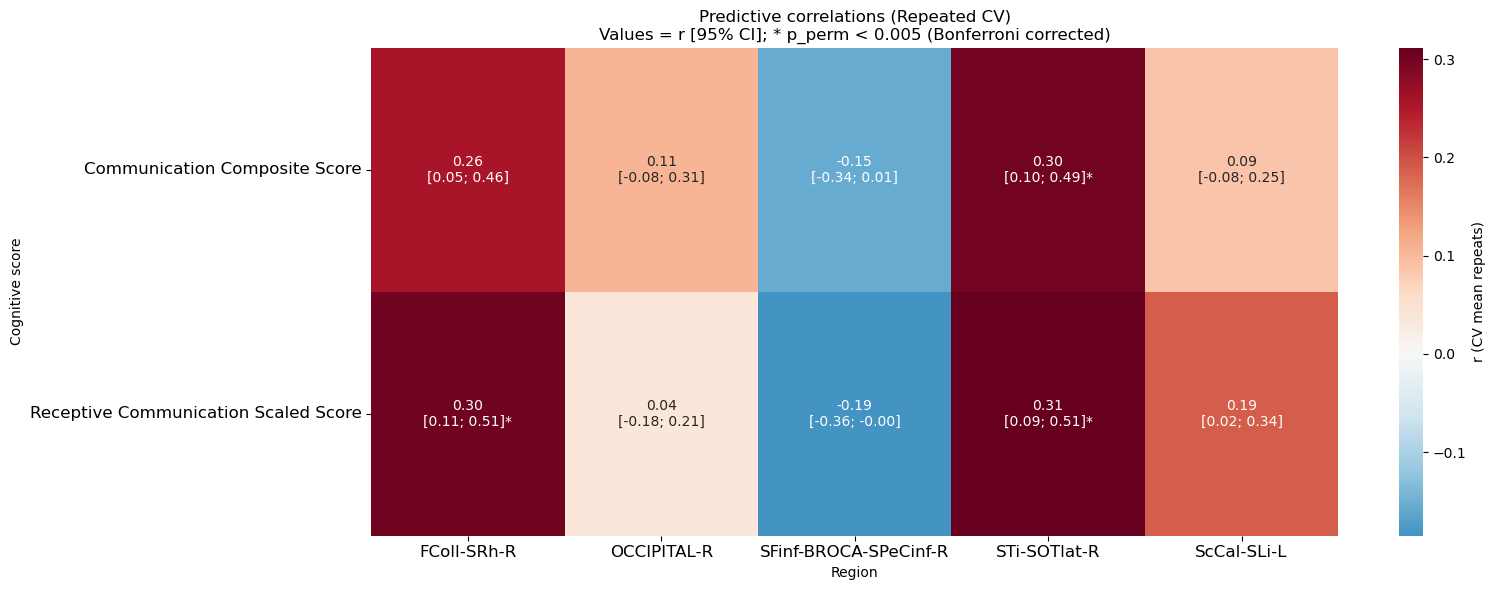

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv(
    "/neurospin/dico/rmenasria/Runs/03_main/Output/final/r_boostraped/dhcp_bootstrap_cognition_perm_resampled copy.csv"
)

df_small = df[[
    "region",
    "score",
    "r_cv_mean_repeats",
    "r_cv_mean_repeats_ci_low",
    "r_cv_mean_repeats_ci_high",
    "r_perm_pvalue_one_sided"
]]

# Only receptive communication score and communication composite score
df_small = df_small[df_small["score"].isin([
    "Receptive Communication Scaled Score",
    "Communication Composite Score"
])]

pivot = df_small.pivot(index="score", columns="region", values="r_cv_mean_repeats")


# Create annotation matrix with r + CI + star
def make_label(r, low, high, pval):
    if pd.isna(r):
        return ""
    star = "*" if pval < 0.05/10 else ""
    return f"{r:.2f}\n[{low:.2f}; {high:.2f}]{star}"

annot = df_small.pivot(index="score", columns="region", values="r_cv_mean_repeats").copy()
for i in annot.index:
    for j in annot.columns:
        row = df_small[(df_small["score"] == i) & (df_small["region"] == j)].iloc[0]
        annot.loc[i, j] = make_label(
            row["r_cv_mean_repeats"],
            row["r_cv_mean_repeats_ci_low"],
            row["r_cv_mean_repeats_ci_high"],
            row["r_perm_pvalue_one_sided"]
        )

# remplacer les suffixes par -L/-R
df_small["region"] = df_small["region"].str.replace("_left$", "-L", regex=True)
df_small["region"] = df_small["region"].str.replace("_right$", "-R", regex=True)

pivot = df_small.pivot(index="score", columns="region", values="r_cv_mean_repeats")

# idem pour annot
annot = pivot.copy()
for i in annot.index:
    for j in annot.columns:
        row = df_small[(df_small["score"] == i) & (df_small["region"] == j)].iloc[0]
        annot.loc[i, j] = make_label(
            row["r_cv_mean_repeats"],
            row["r_cv_mean_repeats_ci_low"],
            row["r_cv_mean_repeats_ci_high"],
            row["r_perm_pvalue_one_sided"]
        )

# Heatmap avec labels plus courts
plt.figure(figsize=(16, 6))
ax = sns.heatmap(
    pivot, annot=annot, fmt="", cmap="RdBu_r", center=0,
    cbar_kws={"label": "r (CV mean repeats)"}
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

plt.title("Predictive correlations (Repeated CV)\nValues = r [95% CI]; * p_perm < 0.005 (Bonferroni corrected)")
plt.ylabel("Cognitive score")
plt.xlabel("Region")
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd 



df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/r_boostraped/dhcp_bootstrap_cognition_perm_all_regions.csv")

# order by r_cv_mean_repeats
df_sorted = df.sort_values(by="r_cv_mean_repeats", ascending=False)
top10 = df_sorted.head(20)
print(top10[[
    "region",
    "score",
    "r_cv_mean_repeats",
    "r_cv_mean_repeats_ci_low",
    "r_cv_mean_repeats_ci_high",
    "r_perm_pvalue_one_sided"
]])

df_receptive_score = df[df["score"] == "Receptive Communication Scaled Score"]
df_composite_score = df[df["score"] == "Composite Score"]

# add columns in each df for p < 0.05/10 and r_cv_mean_repeats > 0 for expressive score and composite score

df_receptive_score["filtered_r"] = np.where(
    (df_receptive_score["r_perm_pvalue_one_sided"] < 0.05/10) &
    (df_receptive_score["r_cv_mean_repeats_ci_low"] > 0),
    df_receptive_score["r_cv_mean_repeats"],  # garde le score brut
    0.0                                       # sinon 0
)

df_composite_score["filtered_r"] = np.where(
    (df_composite_score["r_perm_pvalue_one_sided"] < 0.05/10) &
    (df_composite_score["r_cv_mean_repeats_ci_low"] > 0),
    df_composite_score["r_cv_mean_repeats"],
    0.0
)


# save to csv
df_receptive_score.to_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/whole_brain_visu/dhcp_receptive_score_all_regions.csv", index=False)
df_composite_score.to_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/whole_brain_visu/dhcp_composite_score_all_regions.csv", index=False)






                           region                                  score  \
240  FCLp-subsc-FCLa-INSULA_right                        Composite Score   
172             FCMpost-SpC_right   Receptive Communication Scaled Score   
112            STi-STs-STpol_left   Receptive Communication Scaled Score   
114            STi-STs-STpol_left        Sum Communication Scaled Scores   
111            STi-STs-STpol_left          Communication Composite Score   
1                    SC-sylv_left          Communication Composite Score   
4                    SC-sylv_left        Sum Communication Scaled Scores   
110            STi-STs-STpol_left                        Composite Score   
171             FCMpost-SpC_right          Communication Composite Score   
174             FCMpost-SpC_right        Sum Communication Scaled Scores   
163                     STs_right  Expressive Communication Scaled Score   
238           STi-STs-STpol_right  Expressive Communication Scaled Score   
178         

/tmp/ipykernel_3779350/4080923605.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_receptive_score["filtered_r"] = np.where(
/tmp/ipykernel_3779350/4080923605.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_composite_score["filtered_r"] = np.where(


In [21]:
df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/r_boostraped/dhcp_bootstrap_cognition_prema_perm_all_regions.csv")

# order by r_cv_mean_repeats
df_sorted = df.sort_values(by="r_cv_mean_repeats", ascending=False)
top10 = df_sorted.head(20)
print(top10[[
    "region",
    "score",
    "r_cv_mean_repeats",
    "r_cv_mean_repeats_ci_low",
    "r_cv_mean_repeats_ci_high",
    "r_perm_pvalue_one_sided"
]])

                          region                                  score  \
115  FCLp-subsc-FCLa-INSULA_left                        Composite Score   
177             STi-SOTlat_right   Receptive Communication Scaled Score   
160                    STs_right                        Composite Score   
232              FColl-SRh_right   Receptive Communication Scaled Score   
176             STi-SOTlat_right          Communication Composite Score   
162                    STs_right   Receptive Communication Scaled Score   
179             STi-SOTlat_right        Sum Communication Scaled Scores   
175             STi-SOTlat_right                        Composite Score   
178             STi-SOTlat_right  Expressive Communication Scaled Score   
213             SsP-SPaint_right  Expressive Communication Scaled Score   
214             SsP-SPaint_right        Sum Communication Scaled Scores   
211             SsP-SPaint_right          Communication Composite Score   
231              FColl-SR

In [24]:
def regression_projection_ranked(
    data: PreparedData,
    alpha: float = 1.0
) -> pd.DataFrame:
    """
    Fit une Ridge sur X->y (avec residualisation sexe + scaling),
    puis retourne un DataFrame des individus triés par projection
    sur la direction du modèle.
    """
    pipe = Pipeline([
        ('resid', ResidualizerSexeFromX()),
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=alpha))
    ])
    pipe.fit(data.X, data.y)

    # Projection brute des individus
    projection = pipe.predict(data.X)

    df = pd.DataFrame({
        "subject": data.groups,   # identifiant sujet
        "y_true": data.y,         # score cognitif
        "projection": projection  # projection sur la direction
    })

    # trier du plus grand au plus petit
    df = df.sort_values(by="projection", ascending=False).reset_index(drop=True)
    return df


In [25]:
# exemple: région + score cognitif
data = prepare_dhcp_for_score(
    "FColl-SRh_right",
    "Receptive Communication Scaled Score",
    prem_class=['<28','28-32','32-37']
)

df_proj = regression_projection_ranked(data, alpha=1.0)

# sauvegarde CSV
df_proj.to_csv(
    "/neurospin/dico/rmenasria/Runs/03_main/Output/final_direction/dHCP/projection_FColl-SRh_right_receptive_score.csv",
    index=False
)


Filtre prem_class ['<28', '28-32', '32-37']: 354 -> 79


In [29]:
# print top 12 and bottom 12 subjects
print("Top 12 subjects by projection:")
print(df_proj["subject"].head(12))
print("\nBottom 12 subjects by projection:")
print(df_proj["subject"].tail(12))



#put all the subjects id in upper case and save to csv

df_proj["subject"] = df_proj["subject"].str.upper()
df_proj.to_csv(
    "/neurospin/dico/rmenasria/Runs/03_main/Output/final_direction/dHCP/projection_FColl-SRh_right_receptive_score_uppercase.csv",
    index=False
)


Top 12 subjects by projection:
0     cc00271xx08
1     cc00530xx11
2     cc00136an13
3     cc00284bn13
4     cc00797xx23
5     cc00284an13
6     cc00087an14
7     cc00891xx18
8     cc00618xx16
9     cc00245an15
10    cc00768xx18
11    cc00688xx21
Name: subject, dtype: object

Bottom 12 subjects by projection:
67    cc00804xx12
68    cc00770xx12
69    cc00517xx14
70    cc00694xx19
71    cc00529bn18
72    cc00829xx21
73    cc00526xx15
74    cc00098an17
75    cc00661xx10
76    cc00629xx19
77    cc00218an12
78    cc00152an04
Name: subject, dtype: object


In [22]:
# Charger le fichier des prémas
df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/r_boostraped/dhcp_bootstrap_cognition_prema_perm_all_regions.csv")

# Receptive score uniquement
df_receptive_score = df[df["score"] == "Receptive Communication Scaled Score"].copy()
df_receptive_score["filtered_r"] = np.where(
    (df_receptive_score["r_perm_pvalue_one_sided"] < 0.05/10) &
    (df_receptive_score["r_cv_mean_repeats_ci_low"] > 0),
    df_receptive_score["r_cv_mean_repeats"],
    0.0
)

# Composite score uniquement
df_composite_score = df[df["score"] == "Composite Score"].copy()
df_composite_score["filtered_r"] = np.where(
    (df_composite_score["r_perm_pvalue_one_sided"] < 0.05/10) &
    (df_composite_score["r_cv_mean_repeats_ci_low"] > 0),
    df_composite_score["r_cv_mean_repeats"],
    0.0
)

# Sauvegarder les CSV séparés
out_receptive = "/neurospin/dico/rmenasria/Runs/03_main/Output/final/whole_brain_visu/dhcp_prema_receptive_score_all_regions.csv"
out_composite = "/neurospin/dico/rmenasria/Runs/03_main/Output/final/whole_brain_visu/dhcp_prema_composite_score_all_regions.csv"

df_receptive_score.to_csv(out_receptive, index=False)
df_composite_score.to_csv(out_composite, index=False)

print(f"CSV généré : {out_receptive}")
print(f"CSV généré : {out_composite}")


CSV généré : /neurospin/dico/rmenasria/Runs/03_main/Output/final/whole_brain_visu/dhcp_prema_receptive_score_all_regions.csv
CSV généré : /neurospin/dico/rmenasria/Runs/03_main/Output/final/whole_brain_visu/dhcp_prema_composite_score_all_regions.csv
